### IMPORTING NECESSARY LIBRARIES

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### IMPORTING THE DATASET

In [2]:
Columns=['target','ID','date','flag','user','tweet']
Encoding = "ISO-8859-1"
df = pd.read_csv('D:\Assignments\DAML_DATA.csv', encoding=Encoding, names=Columns)
df.shape

(1600000, 6)

### EXPLORATORY DATA ANALYSIS

In [3]:
df.head()

,target,ID,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
dataset=df[['tweet','target']]

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   tweet   1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


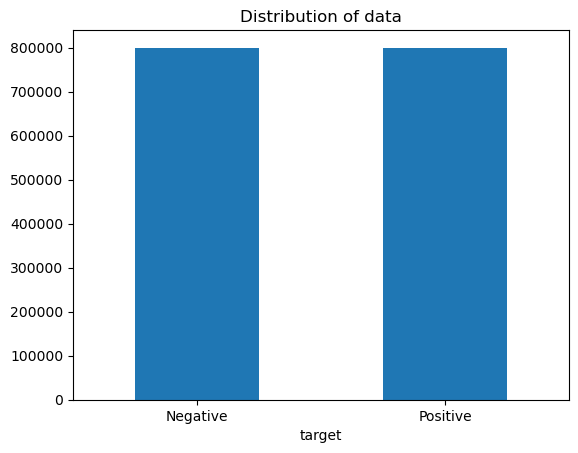

In [6]:
ax = dataset.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
tweet, target = list(dataset['tweet']), list(dataset['target'])

### DATA PRE-PROCESSING

In [7]:
dataset['target'] = dataset['target'].replace(4,1)
dataset['target'].unique()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13220\642255261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['target'].replace(4,1)


array([0, 1], dtype=int64)

In [8]:
positive_count = dataset['target'].value_counts()[0]
negative_count = dataset['target'].value_counts()[1]
print(f"Number of negative tweets (0): {negative_count}")
print(f"Number of positive tweets (1): {positive_count}")

Number of negative tweets (0): 800000
Number of positive tweets (1): 800000


In [9]:
negative_tweets = dataset[dataset['target'] == 0].sample(n=5000, random_state=42)
positive_tweets = dataset[dataset['target'] == 1].sample(n=5000, random_state=42)

data = pd.concat([negative_tweets, positive_tweets])

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(data['target'].value_counts())

1    5000
0    5000
Name: target, dtype: int64


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   10000 non-null  object
 1   target  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


### REMOVING STOPWORDS

In [11]:
data['tweet']=data['tweet'].str.lower()
data['tweet'].head()
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)

def cleaning_stopwords(tweet):
    return " ".join([word for word in str(tweet).split() if word not in STOPWORDS])
data['tweet'] = data['tweet'].apply(lambda tweet: cleaning_stopwords(tweet))
data['tweet'].head()

0             found perfect title portfolio. song love
1    new anti-virus ive installed seems effective, ...
2    fact: still love him...you learn mistakes, hop...
3    think gotta make new twitter account cuz &quot...
4    end weekend....back work tomorrow need longer ...
Name: tweet, dtype: object

### REMOVING PUNCTUATIONS

In [12]:
import string
punctuations_list = string.punctuation
def cleaning_punctuations(tweet):
    translator = str.maketrans('', '', punctuations_list)
    return tweet.translate(translator)
data['tweet']= data['tweet'].apply(lambda x: cleaning_punctuations(x))
data['tweet'].head()

0              found perfect title portfolio song love
1    new antivirus ive installed seems effective st...
2    fact still love himyou learn mistakes hope don...
3    think gotta make new twitter account cuz quots...
4    end weekendback work tomorrow need longer week...
Name: tweet, dtype: object

### REMOVING REPEATING CHARACTERS, URLs, NUMBERS

In [13]:
def cleaning_repeating_char(tweet):
    return re.sub(r'(.)1+', r'1', tweet)
data['tweet'] = data['tweet'].apply(lambda x: cleaning_repeating_char(x))
data['tweet'].head()

0              found perfect title portfolio song love
1    new antivirus ive installed seems effective st...
2    fact still love himyou learn mistakes hope don...
3    think gotta make new twitter account cuz quots...
4    end weekendback work tomorrow need longer week...
Name: tweet, dtype: object

In [14]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['tweet'] = data['tweet'].apply(lambda x: cleaning_URLs(x))
data['tweet'].head()

0              found perfect title portfolio song love
1    new antivirus ive installed seems effective st...
2    fact still love himyou learn mistakes hope don...
3    think gotta make new twitter account cuz quots...
4    end weekendback work tomorrow need longer week...
Name: tweet, dtype: object

In [15]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['tweet'] = data['tweet'].apply(lambda x: cleaning_numbers(x))
data['tweet'].head()

0              found perfect title portfolio song love
1    new antivirus ive installed seems effective st...
2    fact still love himyou learn mistakes hope don...
3    think gotta make new twitter account cuz quots...
4    end weekendback work tomorrow need longer week...
Name: tweet, dtype: object

### PERFORMING STEMMING

In [16]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
data['tweet'] = data['tweet'].apply(lambda x: word_tokenize(x))
data['tweet'].head()

0       [found, perfect, title, portfolio, song, love]
1    [new, antivirus, ive, installed, seems, effect...
2    [fact, still, love, himyou, learn, mistakes, h...
3    [think, got, ta, make, new, twitter, account, ...
4    [end, weekendback, work, tomorrow, need, longe...
Name: tweet, dtype: object

In [18]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    tweet = [st.stem(word) for word in data]
    return data
data['tweet']= data['tweet'].apply(lambda x: stemming_on_text(x))
data['tweet'].head()

0       [found, perfect, title, portfolio, song, love]
1    [new, antivirus, ive, installed, seems, effect...
2    [fact, still, love, himyou, learn, mistakes, h...
3    [think, got, ta, make, new, twitter, account, ...
4    [end, weekendback, work, tomorrow, need, longe...
Name: tweet, dtype: object

### PERFORMING LEMMETIZATION

In [19]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    tweet = [lm.lemmatize(word) for word in data]
    return data
data['tweet'] = data['tweet'].apply(lambda x: lemmatizer_on_text(x))
data['tweet'].head()

0       [found, perfect, title, portfolio, song, love]
1    [new, antivirus, ive, installed, seems, effect...
2    [fact, still, love, himyou, learn, mistakes, h...
3    [think, got, ta, make, new, twitter, account, ...
4    [end, weekendback, work, tomorrow, need, longe...
Name: tweet, dtype: object

### PERFORMING TRAIN-TEST SPLIT

In [21]:
data['tweet_str'] = data['tweet'].apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(data['tweet_str'], data['target'], test_size=0.05, random_state=42)

### PERFORMING VECTORIZATION

In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### LOGISTIC REGRESSION

In [23]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_vec, y_train)

LogisticRegression()

In [24]:
y_pred_lr = logistic_regression.predict(X_test_vec)
print ("Testing accuracy of the Logistic Regression model is: ", accuracy_score(y_test, y_pred_lr))

Testing accuracy of the Logistic Regression model is:  0.764


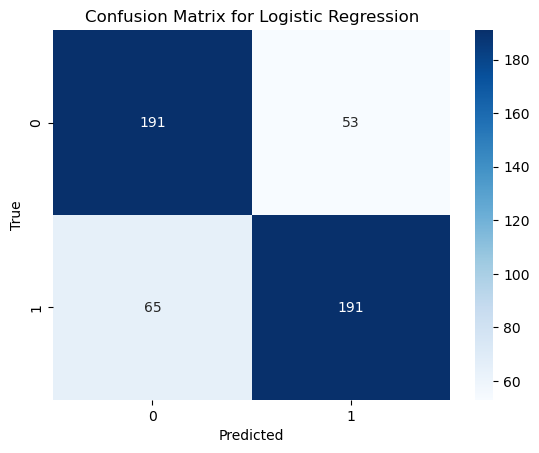

In [25]:
matrix_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(matrix_lr, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

### LSTM

In [26]:
X_train_array = np.array(X_train_vec.toarray())
X_test_array = np.array(X_test_vec.toarray())

In [27]:
time_steps = 10
X_train_reshaped = X_train_array.reshape(-1, time_steps, X_train_array.shape[1] // time_steps)
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_reshaped, y_train, epochs=3, batch_size=64, validation_data=(X_test_array.reshape(-1, time_steps, X_test_array.shape[1] // time_steps), y_test))

Epoch 1/3
149/149 [==============================] - 26s 138ms/step - loss: 0.6681 - accuracy: 0.5876 - val_loss: 0.5767 - val_accuracy: 0.7020
Epoch 2/3
149/149 [==============================] - 15s 102ms/step - loss: 0.4569 - accuracy: 0.7858 - val_loss: 0.5676 - val_accuracy: 0.7000
Epoch 3/3
149/149 [==============================] - 15s 102ms/step - loss: 0.2448 - accuracy: 0.9000 - val_loss: 0.7869 - val_accuracy: 0.6920


In [28]:
y_pred_lstm = (model_lstm.predict(X_test_array.reshape(-1, time_steps, X_test_array.shape[1] // time_steps)) > 0.5).astype("int32")
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"Testing accuracy of the LSTM model is: {accuracy_lstm}")

16/16 [==============================] - 1s 24ms/step
Testing accuracy of the LSTM model is: 0.692


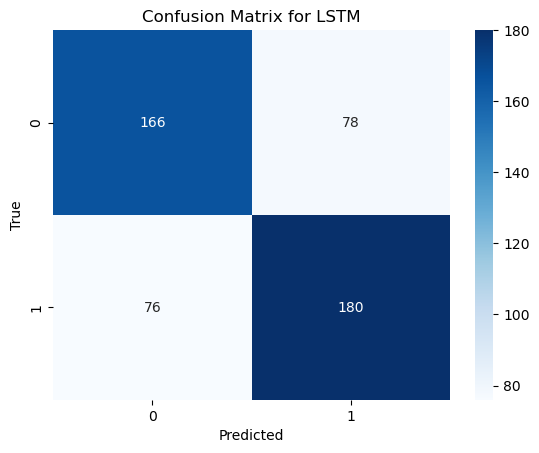

In [29]:
matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(matrix_lstm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for LSTM")
plt.show()

### KNN

In [30]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_vec, y_train)
y_pred_knn = knn_classifier.predict(X_test_vec)

In [31]:
y_pred_knn = knn_classifier.predict(X_test_vec)
print ("Testing accuracy of the KNN model is: ", accuracy_score(y_test, y_pred_knn))

Testing accuracy of the KNN model is:  0.614


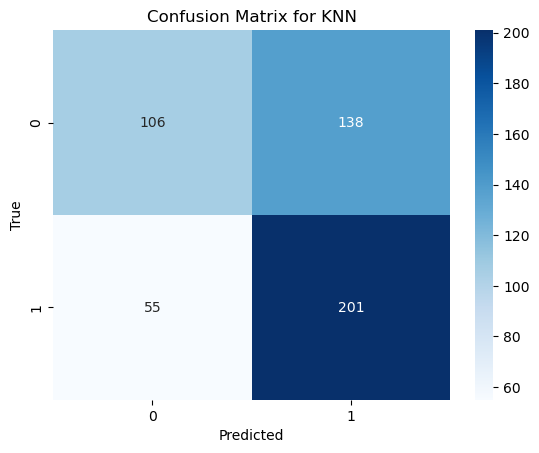

In [32]:
matrix_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(matrix_knn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for KNN")
plt.show()